# Basic eigenmode simulation of side-coupled resonator (Gmsh)

In [ ]:
%load_ext autoreload
%autoreload 2
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
os.environ["PMIX_MCA_gds"]="hash"

# Import useful packages
import qiskit_metal as metal
from qiskit_metal import designs, draw
from qiskit_metal import MetalGUI, Dict, open_docs
from qiskit_metal.toolbox_metal import math_and_overrides
from qiskit_metal.qlibrary.core import QComponent
from collections import OrderedDict

# To create plots after geting solution data.
import matplotlib.pyplot as plt
import numpy as np

# Packages for the simple design
from qiskit_metal.qlibrary.tlines.meandered import RouteMeander
from qiskit_metal.qlibrary.tlines.straight_path import RouteStraight
from qiskit_metal.qlibrary.tlines.pathfinder import RoutePathfinder
from qiskit_metal.qlibrary.terminations.launchpad_wb import LaunchpadWirebond
from qiskit_metal.qlibrary.terminations.open_to_ground import OpenToGround
from qiskit_metal.qlibrary.terminations.short_to_ground import ShortToGround
from qiskit_metal.qlibrary.couplers.coupled_line_tee import CoupledLineTee

# Set up chip design as planar, multiplanar also available
design = designs.DesignPlanar({}, overwrite_enabled=True)

# Set up chip dimensions 
design.chips.main.size.size_x = '4.6mm'
design.chips.main.size.size_y = '2.4mm'
design.chips.main.size.size_z = '-280um'
design.chips.main.size.center_x = '0mm'
design.chips.main.size.center_y = '-1mm'

# Resonator and feedline gap width (W) and center conductor width (S) are set to 50 Ohm 
design.variables['cpw_width'] = '10 um' #S
design.variables['cpw_gap'] = '6 um' #W 


# Create GUI
gui = MetalGUI(design)

# Lauchpad 1
x1 = '-2mm'
y1 = '0mm'
launch_options1 = dict(chip='main', pos_x=x1, pos_y=y1, orientation='360', lead_length='30um', pad_height='103um', 
                      pad_width='103um', pad_gap='60um')
LP1 = LaunchpadWirebond(design, 'LP1', options = launch_options1)

# Launchpad 2
x2 = '2mm'
y1 = '0mm'
launch_options2 = dict(chip='main', pos_x=x2, pos_y=y1, orientation='180', lead_length='30um', pad_height='103um', 
                      pad_width='103um', pad_gap='60um')
LP2 = LaunchpadWirebond(design, 'LP2', options = launch_options2)

# Using path finder to connect the two launchpads
TL = RoutePathfinder(design, 'TL', options = dict(chip='main', trace_width ='10um',
                                            trace_gap ='6um',
                                            fillet='90um',                                                            
                                            hfss_wire_bonds = True,
                                            lead=dict(end_straight='0.1mm'),
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='LP1',
                                                    pin='tie'),
                                                end_pin=Dict(
                                                    component='LP2',
                                                    pin='tie')
                                            )))


######################
# lambda/4 resonator1#
######################
otg1 = OpenToGround(design, 'otg1', options=dict(chip='main', pos_x='-0.2mm',  pos_y='-40um', orientation = 180))
stg1 = ShortToGround(design, 'stg1', options=dict(chip='main', pos_x='0mm',  pos_y='-1.35mm', orientation = -90))

# Use RouteMeander to fix the total length of the resonator
res1 = RouteMeander(design, 'resonator1',  Dict(
        trace_width ='10um',
        trace_gap ='6um',
        total_length='3.7mm',
        hfss_wire_bonds = False,
        fillet='99.9 um',
        lead = dict(start_straight='300um'),
        pin_inputs=Dict(
        start_pin=Dict(component='otg1', pin='open'),
        end_pin=Dict(component='stg1', pin='short')), ))

# rebuild the GUI
gui.rebuild()

Now to run the Palace simulation (**make sure to update the path to the Palace binary first**)

In [ ]:
from SQDMetal.PALACE.Eigenmode_Simulation import PALACE_Eigenmode_Simulation
from SQDMetal.PALACE.SQDGmshRenderer import Palace_Gmsh_Renderer

#Eigenmode Simulation Options
user_defined_options = {
                 "mesh_refinement":  0,                             #refines mesh in PALACE - essetially divides every mesh element in half
                 "dielectric_material": "silicon",                  #choose dielectric material - 'silicon' or 'sapphire'
                 "starting_freq": 5,                              #starting frequency in GHz 
                 "number_of_freqs": 2,                              #number of eigenmodes to find
                 "solns_to_save": 3,                                #number of electromagnetic field visualizations to save
                 "solver_order": 2,                                 #increasing solver order increases accuracy of simulation, but significantly increases sim time
                 "solver_tol": 1.0e-8,                              #error residual tolerance foriterative solver
                 "solver_maxits": 100,                              #number of solver iterations
                 "mesh_max": 120e-3,                                #maxiumum element size for the mesh in mm
                 "mesh_min": 10e-3,                                 #minimum element size for the mesh in mm
                 "mesh_sampling": 130,                              #number of points to mesh along a geometry
                 "fillet_resolution":12,                             #Number of vertices per quarter turn on a filleted path
                 "palace_dir":"PATH/TO/PALACE/BINARY",
                 "num_cpus": 16
                }

#Creat the Palace Eigenmode simulation
eigen_sim = PALACE_Eigenmode_Simulation(name ='GMSH_eigen_test',                              #name of simulation
                                        metal_design = design,                                      #feed in qiskit metal design
                                        sim_parent_directory = "",            #choose directory where mesh file, config file and HPC batch file will be saved
                                        mode = 'simPC',                                               #choose simulation mode 'HPC' or 'simPC'                                          
                                        meshing = 'GMSH',                                         #choose meshing 'GMSH' or 'COMSOL'
                                        user_options = user_defined_options,                        #provide options chosen above
                                        view_design_gmsh_gui = False,                               #view design in GMSH gui 
                                        create_files = True)                                        #create mesh, config and HPC batch files
eigen_sim.add_metallic(1)
eigen_sim.add_ground_plane()

#Add in the RF ports
eigen_sim.create_port_CPW_on_Launcher('LP1', 20e-3) #, 20e-3
eigen_sim.create_port_CPW_on_Launcher('LP2', 20e-3) #, 20e-3

# #Fine-mesh routed paths
eigen_sim.fine_mesh_along_path(100e-6, 'TL', mesh_sampling=130, mesh_min=10e-3, mesh_max=120e-3)
eigen_sim.fine_mesh_along_path(100e-6, 'resonator1', mesh_sampling=130, mesh_min=10e-3, mesh_max=120e-3)

eigen_sim.prepare_simulation()

In [ ]:
eigen_sim.run()

Use this to inspect mesh in Gmsh if required

In [ ]:
#use this to open the gmsh gui, then you can open your mesh file from the gui to view it
import gmsh
gmsh.initialize()
gmsh.model.add('palace')
gmsh.fltk.run()

The data will be stored in the output directory along with pregenerated plots slicing the device plane. Nonetheless, the slices can be manually retrieved via the `PVDVTU_Viewer` class. Either initialise the class directly or via the returned object when calling `retrieve_field_plots`:

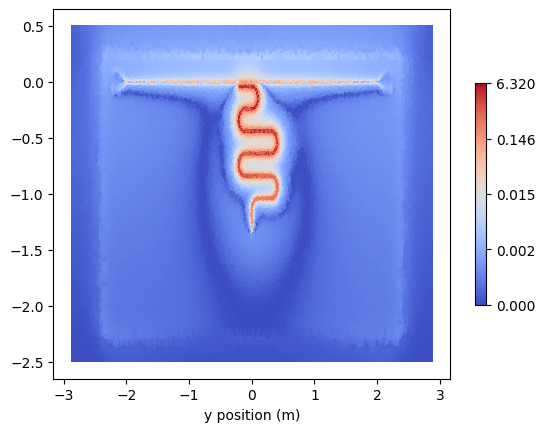

In [ ]:
%matplotlib inline
pvdtu = eigen_sim.retrieve_field_plots()
leSlice = pvdtu.get_data_slice(0)
leSlice.plot(np.linalg.norm(leSlice.get_data('E_real'), axis=1), 'coolwarm', True);